# Inventory System with s, S Policy

Simulate an inventory system with s, S policy with discrete review system. 

The inventory level is checked at regular intervals and an order is placed to bring the inventory level up to S whenever the inventory level drops below s. 

The order quantity is the difference between S and the inventory level at the time of the review.

When demand occurs, it is satisfied immediately if inventory level at least equals the demand size. Otherwise, the demand is backlogged and the inventory level is reduced by the available amount.

When delivery occurs, it is used first to satisfy backlogged demand and then to increase the inventory level.

Suppose:
    - Demand inter-arrival time is exponentially distributed with mean 0.1 months.
    - Demand size is 1, 2, 3, or 4 with probability (1/3, 1/6, 1/6, 1/3), respectively.
    - Inventory level is 60 at the beginning of the simulation.
    - Inventory level is checked every 1 month.
    - Lead time is uniformly distributed between 0.5 and 1 month.
    - The order setup cost is 32.
    - The incremental order cost is 3.
    - The holding cost is 1.
    - The shortage cost is 5.
    
Simulate the system for 120 months and calculate the total cost.

Compare the cost of the system with different s_min and s_max values.


In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import random
import simpy
import statistics

In [2]:
class Warehouse:
     
    def __init__(
        self, 
        env: simpy.Environment,
        demand_inter_arrival_mean_time: float = 0.1,
        demand_distribution: tuple[list[int], list[float]] = ([1, 2, 3, 4], [1/3, 1/6, 1/6, 1/3]),
        inventory_level: float = 60,
        inventory_check_interval: float = 1,
        lead_time_min: float = 0.5,
        lead_time_max: float = 1,
        s_max: float = 40,
        s_min: float = 20,
        order_setup_cost: float = 32,
        order_incremental_cost: float = 3,
        holding_cost: float = 1,
        shortage_cost: float = 5
    ) -> None:
        self.env = env
        self.demand_inter_arrival_mean_time = demand_inter_arrival_mean_time
        self.demand_distribution = demand_distribution
        self._inventory_level = inventory_level
        self.inventory_check_interval = inventory_check_interval
        self.lead_time_min = lead_time_min
        self.lead_time_max = lead_time_max
        self.s_max = s_max
        self.s_min = s_min
        self.order_setup_cost = order_setup_cost
        self.order_incremental_cost = order_incremental_cost
        self.holding_cost = holding_cost
        self.shortage_cost = shortage_cost
        
        self.total_order_cost = 0
        
        self.inventory_history: dict[float, float] = defaultdict(float)
        
        self.it: list[tuple[float, float]] = [(0, inventory_level)]
        self.last_inventory_level: float = inventory_level
        self.last_inventory_level_timestamp: float = 0

        self.env.process(self.inventory_monitor())
        self.env.process(self.demand_generator())

    @property
    def inventory_level(self):
        return self._inventory_level

    @inventory_level.setter
    def inventory_level(self, value):
        # Update last inventory level duration
        self.inventory_history[self.last_inventory_level] += self.env.now - self.last_inventory_level_timestamp
        
        # Set new inventory level
        self._inventory_level = value
        self.it.append((self.env.now, self._inventory_level))
        
        # Update last inventory level
        self.last_inventory_level_timestamp = self.env.now
        self.last_inventory_level = self._inventory_level

    @property
    def total_holding_cost(self) -> float:
        return sum(
            max(inventory_level, 0) * duration * self.holding_cost 
            for inventory_level, duration in self.inventory_history.items()
        )

    @property
    def total_shortage_cost(self) -> float:
        return sum(
            max(-inventory_level, 0) * duration * self.shortage_cost 
            for inventory_level, duration in self.inventory_history.items()
        )

    @property
    def total_cost(self) -> float:
        return self.total_order_cost + self.total_holding_cost + self.total_shortage_cost

    def inventory_monitor(self):
        while True:
            yield self.env.timeout(self.inventory_check_interval)
            if self.inventory_level < self.s_min:
                self.env.process(self.order_up_to_s_max())
    
    def order_up_to_s_max(self):
        z = self.s_max - self.inventory_level
        self.total_order_cost += (self.order_setup_cost + self.order_incremental_cost * z)
        lead_time = random.uniform(self.lead_time_min, self.lead_time_max)
        yield self.env.timeout(lead_time)
        self.inventory_level += z

    def demand_generator(self):
        while True:
            demand_inter_arrival_time = random.expovariate(lambd=1/self.demand_inter_arrival_mean_time)
            pop, weights = self.demand_distribution
            demand_size = random.choices(pop, weights=weights, k=1)[0]
            
            yield self.env.timeout(demand_inter_arrival_time)
            self.inventory_level -= demand_size
    
    def plot_inventory_level(self):
        x, y = zip(*self.it)
        plt.step(x, y, where='post')
        plt.fill_between(x, y, step='post', alpha=0.2)
        plt.title('I(t): Inventory level over time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Inventory Length')
        plt.show()

In [3]:
random.seed(42)
env = simpy.Environment()
warehouse = Warehouse(
    env, 
    demand_inter_arrival_mean_time=0.1, # on average, 0.1 months between demands
    demand_distribution=([1, 2, 3, 4], [1/3, 1/6, 1/6, 1/3]),
    inventory_level=60,
    inventory_check_interval=1,
    lead_time_min=0.5,
    lead_time_max=1,
    s_max=40,
    s_min=20,
    order_setup_cost=32,
    order_incremental_cost=3,
    holding_cost=1,
    shortage_cost=5
)
env.run(until=5)

In [4]:
warehouse.total_cost

428.4780375843177

In [5]:
warehouse.total_order_cost

309

In [6]:
warehouse.total_holding_cost

111.31865583015068

In [7]:
warehouse.total_shortage_cost

8.15938175416704

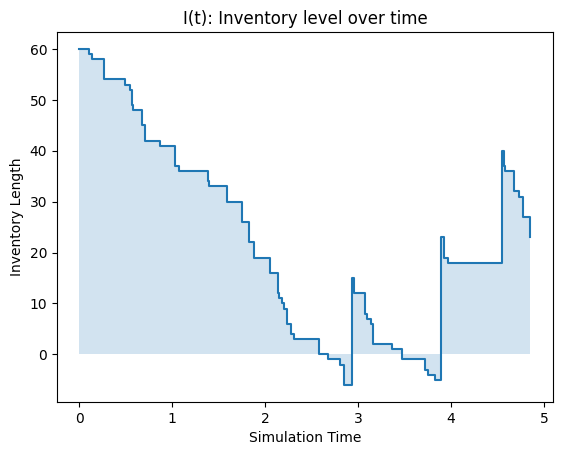

In [8]:
warehouse.plot_inventory_level()

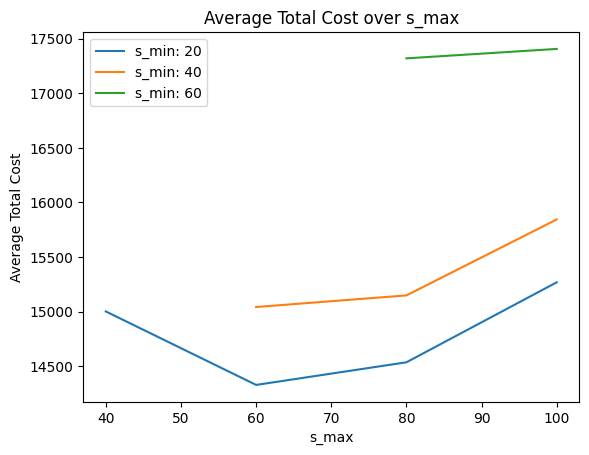

In [9]:
random.seed(None)
params = (
    # (s_min, s_max)
    (20, 40),
    (20, 60),
    (20, 80),
    (20, 100),
    (40, 60),
    (40, 80),
    (40, 100),
    (60, 80),
    (60, 100)
)

results = {}
for s_min, s_max in params:
    for _ in range(30):
        env = simpy.Environment()
        warehouse = Warehouse(env, s_min=s_min, s_max=s_max)
        env.run(until=120)
        results.setdefault(s_min, {}).setdefault(s_max, []).append(warehouse.total_cost)

for s_min, d in results.items():
    s_maxs = list(d.keys())
    average_total_costs = [statistics.mean(l) for l in d.values()]
    plt.plot(s_maxs, average_total_costs, label=f's_min: {s_min}')
    
plt.title('Average Total Cost over s_max')
plt.xlabel('s_max')
plt.ylabel('Average Total Cost')
plt.legend()
plt.show()